In [11]:
import sys
import torch
import numpy as np
from torch_geometric.data import Data
import math
import pandas as pd
import ast
import torch
import matplotlib.pyplot as plt

sys.path.append('/Users/aseth/Documents/GitHub/DegScore')

from arnie.mfe import mfe

from DegScore import DegScore

In [6]:
# mdl = DegScore('GGGUUUCCC', structure='(((...)))')
# print(mdl.degscore_by_position)
# print(mdl.degscore)
# print(mdl.est_half_life)

[0.17  0.217 0.511 0.641 0.714 0.49  0.347 0.15  0.643]
3.8830000000000013
11.430771365678682


In [9]:
def one_hot_nucleotide(seq_char):
    mapping = {'A':0,'G':1,'C':2,'U':3}
    vec = np.zeros(4)
    vec[mapping.get(seq_char,0)] = 1
    return vec

def one_hot_loop_type(lc):
    types = ['E','S','H','I','M','B','X']
    vec = np.zeros(len(types))
    if lc in types:
        vec[types.index(lc)] = 1
    return vec

def parse_structure(structure):
    stack = []
    pairs = []
    for i, ch in enumerate(structure):
        if ch == '(':
            stack.append(i)
        elif ch == ')':
            j = stack.pop()
            pairs.append((i,j))
    return pairs

def positional_embedding(seq_length):
    pos_embed = []
    for i in range(seq_length):
        pos_embed.append([math.sin(i/1000), math.cos(i/1000), math.sin(i/100), math.cos(i/100)])
    return np.array(pos_embed, dtype=np.float32)

# Load your fine-tuned model (FineTuneModel)
from pretrain_then_supervised import FineTuneModel

DEVICE = "cpu"
HIDDEN_DIM = 128
HEADS = 4
LAYERS = 4
DROPOUT = 0.2

model = FineTuneModel(in_dim=15, hid_dim=HIDDEN_DIM, out_dim=5, layers=LAYERS, heads=HEADS, dropout=DROPOUT)
model.load_state_dict(torch.load("supervised.pt", map_location=torch.device('cpu'), weights_only=True))
model.to(DEVICE)
model.eval()

# # Example sequence and structure
# sequence = "GGAAAUUUUCGCGGGACGGGCGGCCGGGCGGAGGCGGCGCGAGGGCGGGAGGACGGGCGCGGAGCGGGCGCGAGGCAGGGCGGCCGGCGGAGCGCGGGUUCGCCCGCGCAAAAGAAACAACAACAACAAC"
# structure = ".......(((((.((.((..(.(((..(((...((..((((....((......))..))))..))...)))..))).)..)).)).)))))(((((((....)))))))....................."  # Example dot-bracket structure; must match the length of sequence
# predicted_loop_type = "EEEEEEESSSSSISSISSIISISSSIISSSIIISSIISSSSIIIISSHHHHHHSSIISSSSIISSIIISSSIISSSISIISSISSISSSSSSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE"  # example loop type string, length = len(sequence)

FineTuneModel(
  (input_lin): Linear(in_features=15, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (layers): ModuleList(
    (0-3): 4 x ResidualTransformerLayer(
      (conv): TransformerConv(128, 128, heads=4)
      (norm): LayerNorm(512, affine=True, mode=graph)
      (proj): Linear(in_features=512, out_features=128, bias=True)
      (act): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (out_lin): Linear(in_features=128, out_features=5, bias=True)
)

Model MAEs:
Reactivity MAE: 5.4655
deg_Mg_pH10 MAE: 10.7995
deg_Mg_50C MAE: 9.6286

DegScore MAEs (only for Mg_pH10 and Mg_50C):
deg_Mg_pH10 MAE: 8.0331
deg_Mg_50C MAE: 8.2885


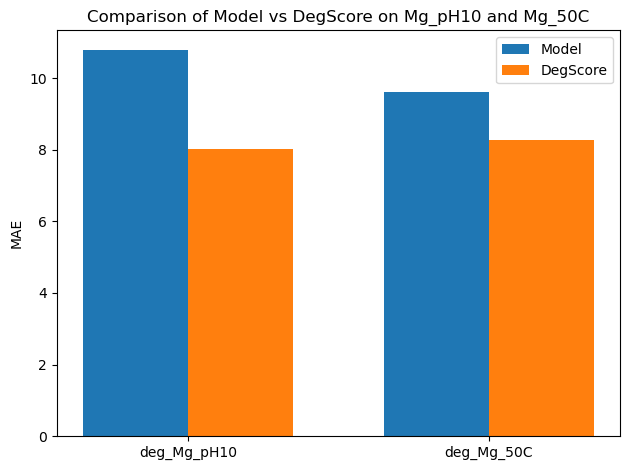


Conclusion:
For deg_Mg_pH10:
DegScore is superior.
For deg_Mg_50C:
DegScore is superior.


In [12]:
# Load the CSV
df = pd.read_csv('../raw_data/stanford-covid-vaccine/post_deadline_files/private_test_labels.csv')

mae_reactivity = []
mae_deg_Mg_pH10 = []
mae_deg_Mg_50C = []

mae_degscore_Mg_pH10 = []
mae_degscore_Mg_50C = []

for idx, row in df.iterrows():
    sequence = row['sequence']
    structure = row['structure']
    loop_type = row['predicted_loop_type']

    # Parse arrays
    reactivity_true = ast.literal_eval(row['reactivity'])
    deg_Mg_pH10_true = ast.literal_eval(row['deg_Mg_pH10'])
    deg_Mg_50C_true = ast.literal_eval(row['deg_Mg_50C'])

    seq_length = len(sequence)
    pos_embed = positional_embedding(seq_length)

    # Node features
    node_feats = []
    for i in range(seq_length):
        nt_feat = one_hot_nucleotide(sequence[i])
        lt_feat = one_hot_loop_type(loop_type[i])
        node_feat = np.concatenate([nt_feat, lt_feat, pos_embed[i]])
        node_feats.append(node_feat)
    node_feats = np.array(node_feats, dtype=np.float32)

    # Edges
    edge_index = []
    for i in range(seq_length-1):
        edge_index.append([i,i+1])
        edge_index.append([i+1,i])
    pairs = parse_structure(structure)
    for (p,q) in pairs:
        edge_index.append([p,q])
        edge_index.append([q,p])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(
        x=torch.tensor(node_feats, dtype=torch.float),
        edge_index=edge_index
    )

    with torch.no_grad():
        pred = model(data.x, data.edge_index).cpu().numpy()
    # pred shape: [N,5] = [reactivity, deg_Mg_pH10, deg_Mg_50C, deg_pH10, deg_50C]
    # We only focus on first 3 for error calculation:
    # Note: Some sequences may have shorter "scored" regions, we must handle that
    scored_length = len(reactivity_true)  # or row['seq_scored'] if available

    pred_reactivity = pred[:scored_length,0]
    pred_deg_Mg_pH10 = pred[:scored_length,1]
    pred_deg_Mg_50C = pred[:scored_length,2]

    # Compute sums
    true_sum_reactivity = np.nansum(reactivity_true)
    true_sum_deg_Mg_pH10 = np.nansum(deg_Mg_pH10_true)
    true_sum_deg_Mg_50C = np.nansum(deg_Mg_50C_true)

    pred_sum_reactivity = np.nansum(pred_reactivity)
    pred_sum_deg_Mg_pH10 = np.nansum(pred_deg_Mg_pH10)
    pred_sum_deg_Mg_50C = np.nansum(pred_deg_Mg_50C)

    # Compute absolute errors
    mae_reactivity.append(abs(pred_sum_reactivity - true_sum_reactivity))
    mae_deg_Mg_pH10.append(abs(pred_sum_deg_Mg_pH10 - true_sum_deg_Mg_pH10))
    mae_deg_Mg_50C.append(abs(pred_sum_deg_Mg_50C - true_sum_deg_Mg_50C))

    # DegScore baseline
    # If we have structure, we can do:
    # DegScore also allows no structure by passing package='eternafold'
    # We'll assume structure is available.
    mdl = DegScore(sequence, structure=structure)

    degscore = mdl.degscore
    # Compare degscore to sums of deg_Mg_pH10 and deg_Mg_50C:
    mae_degscore_Mg_pH10.append(abs(degscore - true_sum_deg_Mg_pH10))
    mae_degscore_Mg_50C.append(abs(degscore - true_sum_deg_Mg_50C))

# Compute mean MAEs
final_mae_reactivity = np.mean(mae_reactivity)
final_mae_Mg_pH10 = np.mean(mae_deg_Mg_pH10)
final_mae_Mg_50C = np.mean(mae_deg_Mg_50C)

degscore_mae_Mg_pH10 = np.mean(mae_degscore_Mg_pH10)
degscore_mae_Mg_50C = np.mean(mae_degscore_Mg_50C)

print("Model MAEs:")
print(f"Reactivity MAE: {final_mae_reactivity:.4f}")
print(f"deg_Mg_pH10 MAE: {final_mae_Mg_pH10:.4f}")
print(f"deg_Mg_50C MAE: {final_mae_Mg_50C:.4f}")

print("\nDegScore MAEs (only for Mg_pH10 and Mg_50C):")
print(f"deg_Mg_pH10 MAE: {degscore_mae_Mg_pH10:.4f}")
print(f"deg_Mg_50C MAE: {degscore_mae_Mg_50C:.4f}")

# Simple side-by-side visualization
labels = ['deg_Mg_pH10', 'deg_Mg_50C']
model_errors = [final_mae_Mg_pH10, final_mae_Mg_50C]
degscore_errors = [degscore_mae_Mg_pH10, degscore_mae_Mg_50C]

x = np.arange(len(labels))  # label locations
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, model_errors, width, label='Model')
rects2 = ax.bar(x + width/2, degscore_errors, width, label='DegScore')

ax.set_ylabel('MAE')
ax.set_title('Comparison of Model vs DegScore on Mg_pH10 and Mg_50C')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

print("\nConclusion:")
print("For deg_Mg_pH10:")
if final_mae_Mg_pH10 < degscore_mae_Mg_pH10:
    print("Model is superior.")
else:
    print("DegScore is superior.")

print("For deg_Mg_50C:")
if final_mae_Mg_50C < degscore_mae_Mg_50C:
    print("Model is superior.")
else:
    print("DegScore is superior.")

Not ideal, still some work to do.